# Project 3: Integer programming

## Introduction to Fantasy Football

Fantasy football is a game where a group of participants serve as general managers of their own virtual football team. Managers build their roster (team) through a draft process in which they select real NFL players. Each team is completely unique because a player can only be on one manager's roster. The performance of a team is determined by the number of points generated by its players, and a player's points are a direct function of their real world performance statistics. As a manager, your goal is to draft the team that generates the most points.

Although there are many different fantasy draft mechanisms, the mechanism we are interested in is an auction draft. An auction draft can be thought of as a set of sequential player auctions where the highest bidding manager wins the player and pays their bid. Each manager is endowed with a budget of 200 to spend in the draft. You have been provided a data set that includes an expected price for each player. You can think of this as the price you must pay to win the player. During the draft you will select a total of 15 players.

In addition to drafting the team, a manager is also responsible for choosing a weekly starting lineup. A starting lineup consists of 1 QB, 3 WR, 2 RB, 1 TE, 1 K, and 1 DEF. Any player not selected to be in your starting lineup is on your bench. Your team generates points from the players you choose to be in your starting lineup. In order to simplify the problem, the optimization will not have to choose a starting lineup for each week. Instead, we will assume that you will start the players with the highest season long points every week and discount a portion of the points generate by your bench players. This means you will receive all points generate by players chosen as starters but only a portion of the points generate by players on your bench. The discount factor to use for bench player is defined in 9 below.

You can download the dataset as a csv file from here:

[Project 2 Data](https://drive.google.com/file/d/1AKgAsyHXOZLRh0urpd4Ng_K_c3g3QA6m/view) (Links to an external site.)



## General Parameters
- You have a maximum budget of 200.
- A roster consists of exactly 15 players.
- A roster has 1 QB slot, 3 WR slots, 2 RB slots, 1 TE slot, 1 K slot, 1 DEF slot, and 6 Bench slots.
- Any QB, WR, RB, TE, K, DEF slot can only contain a player of that type.
- A Bench slot can contain any player type.
- A player on your roster can only be assigned to one slot.
- You want at most 2 QB and 2 TE on your roster.
- You want at most 1 K and 1 DEF on your roster.
- A player on your bench will only generate a fraction of their projected points. A bench player should generate $\delta(d) = \frac{1}{2}^d$ of their projected points where d is their depth at their position and $\delta$ is the discount applied to their points. For example, if you have RB1, RB2, RB3, and RB4 on your team with projected points P1, P2, P3, and P4 the expected points from these players would be $P1 + P2 + \frac{1}{2} P3 + \frac{1}{4} P4$


## Questions to answer
1. Who would you choose to maximize points while staying within budget?
2. How many points is your team expected to generate?
3. How much of your budget did you spend?


All of these questions can be answered by writing an Integer Program in python. Please submit your solution with the questions answered in the form of a pdf, .py, or .ipynb file(s).





This project is about fantasy football. However, I realize that many of you may not have any interest in football or its fantasy alternatives.  If you, like my wife, have general disdain and/or lack of knowledge for the sport and need clarification on anything feel free to reach out on slack or email.

In [2]:
! pip install ortools

In [3]:
import random
import pandas as pd
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
fantasy_df = pd.read_csv("/content/fantasy_football_data.csv")
fantasy_df.head()

,Name,Position,Team,ProjectedPoints,Price
0,Aaron Rodgers,QB,GBP,333.5,51.2
1,Tom Brady,QB,NEP,312.1,38.3
2,Drew Brees,QB,NOS,306.2,36.3
3,Matt Ryan,QB,ATL,294.3,29.2
4,Russell Wilson,QB,SEA,287.9,25.8


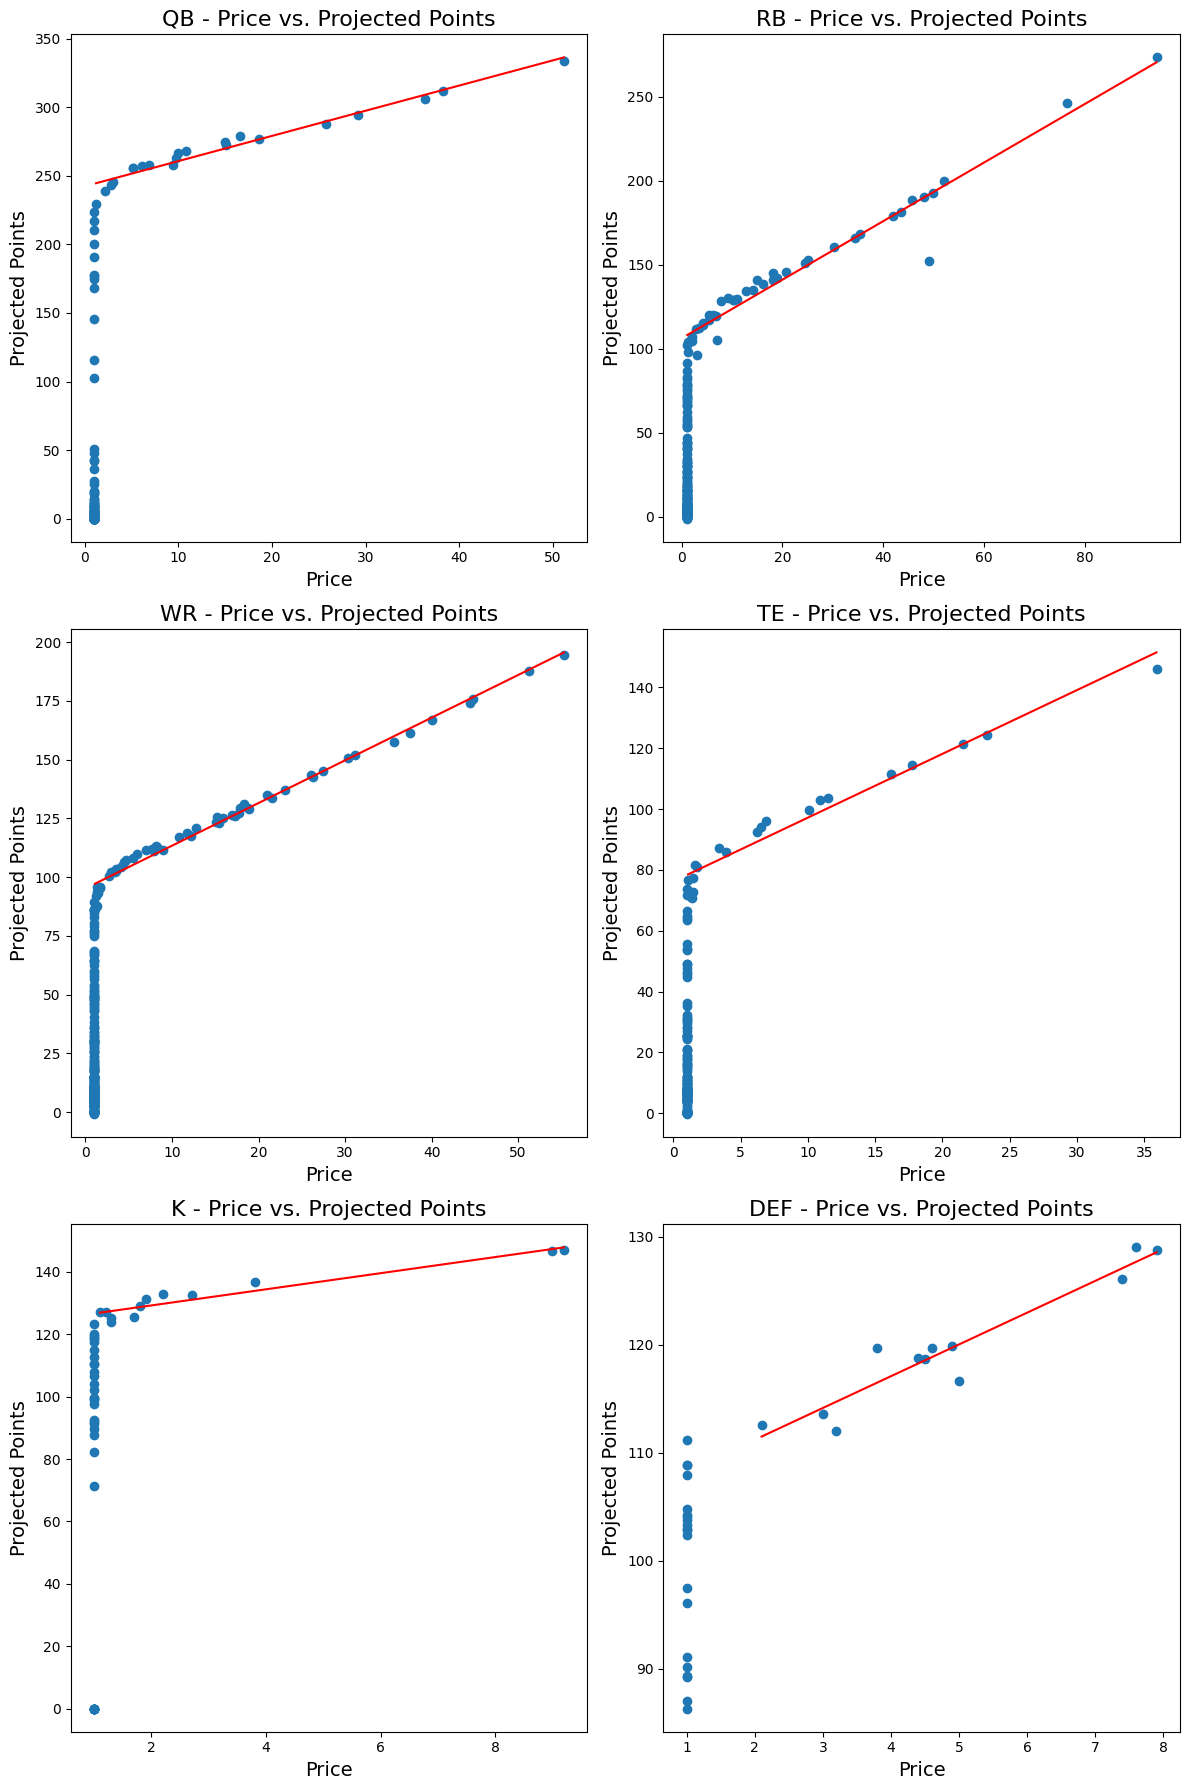


Regression Equations by Position:
QB: y = 1.84x + 242.38
RB: y = 1.74x + 106.35
WR: y = 1.82x + 95.18
TE: y = 2.10x + 76.20
K: y = 2.58x + 124.10
DEF: y = 2.94x + 105.31


In [5]:

positions = ['QB', 'RB', 'WR', 'TE', 'K', 'DEF']

# Create a 3x2 subplot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Define font sizes
title_fontsize = 16
label_fontsize = 14

# Dictionary to store regression equations
regression_equations = {}

# Iterate through each position and create a scatter plot with regression line
for i, pos in enumerate(positions):
    # Filter data for the current position
    pos_data = fantasy_df[fantasy_df['Position'] == pos]

    # Exclude players with a price of one from the regression calculation
    regression_data = pos_data[pos_data['Price'] > 1]

    # Calculate regression
    if len(regression_data) > 1:  # Ensure there are enough points for regression
        m, b = np.polyfit(regression_data['Price'], regression_data['ProjectedPoints'], 1)

        # Store the equation
        regression_equations[pos] = f"y = {m:.2f}x + {b:.2f}"

        # Plot regression line
        axes[i].plot(regression_data['Price'], m * regression_data['Price'] + b, color='red')

    # Plotting scatter plot
    axes[i].scatter(pos_data['Price'], pos_data['ProjectedPoints'])
    axes[i].set_title(f'{pos} - Price vs. Projected Points', fontsize=title_fontsize)
    axes[i].set_xlabel('Price', fontsize=label_fontsize)
    axes[i].set_ylabel('Projected Points', fontsize=label_fontsize)

# Adjust layout
plt.tight_layout()
plt.show()

# Print the regression equations
print("\nRegression Equations by Position:")
for pos, equation in regression_equations.items():
    print(f"{pos}: {equation}")

In [6]:
name_list = fantasy_df['Name'].tolist()
position_list = fantasy_df['Position'].tolist()
team_list = fantasy_df['Team'].tolist()
projected_points_list = fantasy_df['ProjectedPoints'].tolist()
price_list = fantasy_df['Price'].tolist()
num_players = len(name_list)

In [7]:
bad_solver = pywraplp.Solver.CreateSolver('SCIP')

In [8]:
# Create variables
starter_vars = [bad_solver.BoolVar(name + '_starter') for name in name_list]
bench_vars = [bad_solver.BoolVar(name + '_bench') for name in name_list]

print(bad_solver.NumVariables())

1904


In [9]:
# Starters
bad_solver.Add(sum(starter_vars[i] for i in range(num_players) if position_list[i] == 'QB') == 1)
bad_solver.Add(sum(starter_vars[i] for i in range(num_players) if position_list[i] == 'RB') == 2)
bad_solver.Add(sum(starter_vars[i] for i in range(num_players) if position_list[i] == 'WR') == 3)
bad_solver.Add(sum(starter_vars[i] for i in range(num_players) if position_list[i] == 'TE') == 1)
bad_solver.Add(sum(starter_vars[i] for i in range(num_players) if position_list[i] == 'K') == 1)
bad_solver.Add(sum(starter_vars[i] for i in range(num_players) if position_list[i] == 'DEF') == 1)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7cb4c005a100> >

In [10]:
# Bench
bad_solver.Add(sum(bench_vars[i] for i in range(num_players) if position_list[i] == 'QB') <= 1)
bad_solver.Add(sum(bench_vars[i] for i in range(num_players) if position_list[i] == 'TE') <= 1)
bad_solver.Add(sum(bench_vars[i] for i in range(num_players) if position_list[i] == 'K') == 0)
bad_solver.Add(sum(bench_vars[i] for i in range(num_players) if position_list[i] == 'DEF') == 0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7cb4c005b000> >

In [11]:
# Limits each player to one list
for starter, bench in zip(starter_vars, bench_vars):
    bad_solver.Add(starter + bench <= 1)

# 9 Starters and 6 Bench Players
bad_solver.Add(sum(starter_vars) == 9)  # Total starters: 1 QB, 3 WR, 2 RB, 1 TE, 1 K, 1 DEF
bad_solver.Add(sum(bench_vars) == 6)  # Total bench players

# Budget Constraint
bad_solver.Add(sum(price_list[i] * (starter_vars[i] + bench_vars[i]) for i in range(num_players)) <= 200)
print(bad_solver.NumConstraints())

965


In [12]:
bad_solver.Maximize(
    sum(projected_points_list[i] * starter_vars[i] for i in range(num_players))  # Full points for starters
    + sum(projected_points_list[i] * 0.5 * bench_vars[i] for i in range(num_players))  # Half points for bench players
)

In [13]:
status = bad_solver.Solve()

In [14]:
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found for the bad model.\n")

    # Initialize total points and total cost
    total_contributed_points = 0
    total_cost = 0

    # Header for the output
    header = "{:<20} {:<10} {:<14} {:<15} {:<15} {:<17} {:<10} {:<10}"
    print(header.format("Player", "Position", "Proj Points", "Proj Points/$", "Contrib Points", "Contrib Points/$", "Price", "Depth"))

    # Iterate through players and print their details
    for i in range(num_players):
      player_selected = starter_vars[i].solution_value() > 0.5 or bench_vars[i].solution_value() > 0.5
      if player_selected:
          is_starter = starter_vars[i].solution_value() > 0.5
          contributed_points = projected_points_list[i] * (1 if is_starter else 0.5)  # Full points for starters, half for bench
          player_cost = price_list[i]
          projected_points_per_price = round(projected_points_list[i] / player_cost if player_cost != 0 else 0, 2)
          contributed_points_per_price = round(contributed_points / player_cost if player_cost != 0 else 0, 2)
          total_contributed_points += contributed_points
          total_cost += player_cost

          player_role = "starter" if is_starter else "bench"
          player_line = "{:<20} {:<10} {:<14} {:<15} {:<15} {:<17} {:<10} {:<10}"
          print(player_line.format(name_list[i], position_list[i], projected_points_list[i], projected_points_per_price, contributed_points, contributed_points_per_price, player_cost, player_role))

# Print total points and total cost
print("\nTotal projected points contributed:", total_contributed_points)
print("Total team cost:", total_cost)

Optimal solution found for the bad model.

Player               Position   Proj Points    Proj Points/$   Contrib Points  Contrib Points/$  Price      Depth     
Cam Newton           QB         278.8          16.8            278.8           16.8              16.6       starter   
Tyrod Taylor         QB         255.8          50.16           127.9           25.08             5.1        bench     
Ty Montgomery        RB         140.9          9.46            140.9           9.46              14.9       starter   
C.J. Anderson        RB         128.8          16.3            128.8           16.3              7.9        starter   
Terrance West        RB         120.1          21.84           60.05           10.92             5.5        bench     
Spencer Ware         RB         115.5          26.86           57.75           13.43             4.3        bench     
Matt Forte           RB         112.2          32.06           56.1            16.03             3.5        bench     
Jonat

Good linear model

In [15]:
name_list = fantasy_df['Name'].tolist()
position_list = fantasy_df['Position'].tolist()
team_list = fantasy_df['Team'].tolist()
projected_points_list = fantasy_df['ProjectedPoints'].tolist()
price_list = fantasy_df['Price'].tolist()
num_players = len(name_list)

In [16]:
solver = pywraplp.Solver.CreateSolver('SCIP')

In [17]:
# Create variables for each depth level
depth1_vars = [solver.BoolVar(name + '_depth1') for name in name_list]  # Starters
depth2_vars = [solver.BoolVar(name + '_depth2') for name in name_list]  # Bench Depth 2
depth3_vars = [solver.BoolVar(name + '_depth3') for name in name_list]  # Bench Depth 3
depth4_vars = [solver.BoolVar(name + '_depth4') for name in name_list]  # Bench Depth 4
print(solver.NumVariables())

3808


In [18]:
# Position constraints for each depth
# Depth 1 (Starters)
solver.Add(sum(depth1_vars[i] for i in range(num_players) if position_list[i] == 'QB') == 1)
solver.Add(sum(depth1_vars[i] for i in range(num_players) if position_list[i] == 'RB') == 2)
solver.Add(sum(depth1_vars[i] for i in range(num_players) if position_list[i] == 'WR') == 3)
solver.Add(sum(depth1_vars[i] for i in range(num_players) if position_list[i] == 'TE') == 1)
solver.Add(sum(depth1_vars[i] for i in range(num_players) if position_list[i] == 'K') == 1)
solver.Add(sum(depth1_vars[i] for i in range(num_players) if position_list[i] == 'DEF') == 1)

# Depth 2
solver.Add(sum(depth2_vars[i] for i in range(num_players) if position_list[i] == 'QB') <= 1)
solver.Add(sum(depth2_vars[i] for i in range(num_players) if position_list[i] == 'RB') <= 1)
solver.Add(sum(depth2_vars[i] for i in range(num_players) if position_list[i] == 'WR') <= 1)
solver.Add(sum(depth2_vars[i] for i in range(num_players) if position_list[i] == 'TE') <= 1)
solver.Add(sum(depth2_vars[i] for i in range(num_players) if position_list[i] == 'K') == 0)
solver.Add(sum(depth2_vars[i] for i in range(num_players) if position_list[i] == 'DEF') ==0)

# Depth 3
solver.Add(sum(depth3_vars[i] for i in range(num_players) if position_list[i] == 'QB') == 0)
solver.Add(sum(depth3_vars[i] for i in range(num_players) if position_list[i] == 'RB') <= 1)
solver.Add(sum(depth3_vars[i] for i in range(num_players) if position_list[i] == 'WR') <= 1)
solver.Add(sum(depth3_vars[i] for i in range(num_players) if position_list[i] == 'TE') == 0)
solver.Add(sum(depth3_vars[i] for i in range(num_players) if position_list[i] == 'K') == 0)
solver.Add(sum(depth3_vars[i] for i in range(num_players) if position_list[i] == 'DEF') ==0)

# Depth 4
solver.Add(sum(depth4_vars[i] for i in range(num_players) if position_list[i] == 'QB') == 0)
solver.Add(sum(depth4_vars[i] for i in range(num_players) if position_list[i] == 'RB') <= 1)
solver.Add(sum(depth4_vars[i] for i in range(num_players) if position_list[i] == 'WR') <= 1)
solver.Add(sum(depth4_vars[i] for i in range(num_players) if position_list[i] == 'TE') == 0)
solver.Add(sum(depth4_vars[i] for i in range(num_players) if position_list[i] == 'K') == 0)
solver.Add(sum(depth4_vars[i] for i in range(num_players) if position_list[i] == 'DEF') ==0)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7cb4c50bfa50> >

In [19]:
# One depth per player
for i in range(num_players):
    solver.Add(depth1_vars[i] + depth2_vars[i] + depth3_vars[i] + depth4_vars[i] <= 1)

# Roster size constraint
solver.Add(sum(depth1_vars) == 9)  # 9 Starters
solver.Add(sum(depth2_vars) + sum(depth3_vars) + sum(depth4_vars) == 6)  # 6 Bench players

# Budget constraint
solver.Add(sum(price_list[i] * (depth1_vars[i] + depth2_vars[i] + depth3_vars[i] + depth4_vars[i]) for i in range(num_players)) <= 200)
print(solver.NumConstraints())

979


In [20]:
# Objective function
solver.Maximize(
    sum(projected_points_list[i] * depth1_vars[i] for i in range(num_players))  # Full points for starters
    + sum(projected_points_list[i] * 0.5 * depth2_vars[i] for i in range(num_players))  # Half points for depth 2
    + sum(projected_points_list[i] * 0.25 * depth3_vars[i] for i in range(num_players))  # Quarter points for depth 3
    + sum(projected_points_list[i] * 0.125 * depth4_vars[i] for i in range(num_players))  # One eighth points for depth 4
)

In [21]:
status = solver.Solve()

# Check if a solution is found
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found.\n")

    # Initialize total points and total cost
    total_contributed_points = 0
    total_cost = 0

    # Header for the output
    header = "{:<20} {:<10} {:<14} {:<15} {:<15} {:<17} {:<10} {:<10}"
    print(header.format("Player", "Position", "Proj Points", "Proj Points/$", "Contrib Points", "Contrib Points/$", "Price", "Depth"))

    # Iterate through players and print their details
    for i in range(num_players):
        depth = None
        contributed_points = 0

        # Determine the depth and contributed points
        if depth1_vars[i].solution_value() > 0.5:
            depth = 1
            contributed_points = projected_points_list[i]
        elif depth2_vars[i].solution_value() > 0.5:
            depth = 2
            contributed_points = projected_points_list[i] * 0.5
        elif depth3_vars[i].solution_value() > 0.5:
            depth = 3
            contributed_points = projected_points_list[i] * 0.25
        elif depth4_vars[i].solution_value() > 0.5:
            depth = 4
            contributed_points = projected_points_list[i] * 0.125

        if depth is not None:
            player_cost = price_list[i]
            projected_points_per_price = round(projected_points_list[i] / player_cost if player_cost != 0 else 0,2)
            contributed_points_per_price = round(contributed_points / player_cost if player_cost != 0 else 0,2)
            total_contributed_points += contributed_points
            total_cost += player_cost

            player_line = "{:<20} {:<10} {:<14} {:<15} {:<15} {:<17} {:<10} {:<10}"
            print(player_line.format(name_list[i], position_list[i], projected_points_list[i], projected_points_per_price, contributed_points, contributed_points_per_price, player_cost, depth))

    # Print total points and total cost
    print("\nTotal projected points contributed:", total_contributed_points)
    print("Total team cost:", total_cost)
else:
    print("No optimal solution found.")

Optimal solution found.

Player               Position   Proj Points    Proj Points/$   Contrib Points  Contrib Points/$  Price      Depth     
Cam Newton           QB         278.8          16.8            278.8           16.8              16.6       1         
Tyrod Taylor         QB         255.8          50.16           127.9           25.08             5.1        2         
Ty Montgomery        RB         140.9          9.46            140.9           9.46              14.9       1         
C.J. Anderson        RB         128.8          16.3            128.8           16.3              7.9        1         
Jonathan Stewart     RB         111.7          38.52           55.85           19.26             2.9        2         
Theo Riddick         RB         104.2          80.15           26.05           20.04             1.3        3         
Antonio Brown        WR         194.6          3.52            194.6           3.52              55.3       1         
Julio Jones          WR

1. Who would you choose to maximize points while staying within budget?

I'd pick this lineup above^

2. How many points is your team expected to generate?

1754.25 points

3. How much of your budget did you spend?

I spent all $200